In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from catboost import CatBoostRegressor
import joblib
import pickle
plt.rcParams['figure.figsize'] = (10,6)

**Data Cleaning and EDA**

In [2]:
Data = pd.read_csv('Bengaluru_House_Data.csv')

In [3]:
Data.head(3)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00


In [4]:
Data.shape

(13320, 9)

In [5]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
Data.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [7]:
Data2 = Data.drop(['area_type', 'availability', 'society', 'balcony'], axis=1,)
Data2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [8]:
Data2.isna().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [9]:
Data3 = Data2.dropna()
Data3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [10]:
Data3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
Data3['bhk'] = Data3['size'].apply(lambda x: int(x.split(' ')[0]))

C:\Users\Chibuzor\.conda\envs\Tensor_Flow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
Data3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [13]:
Data3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

In [14]:
Data3[Data3.bhk>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [15]:
Data3.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [16]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [17]:
Data3[~Data3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [18]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [19]:
Data4 = Data3.copy()
Data4['total_sqft'] = Data4['total_sqft'].apply(convert_sqft_to_num)

In [20]:
Data4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


**Feature Engineering and Dimensionality Reduction**

In [21]:
Data5 = Data4.copy()

In [22]:
Data5['price_per_sqft'] = (Data5['price']*100000) / (Data5['total_sqft'])
Data5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [23]:
len(Data5.location.unique())

1304

In [24]:
Data5['location'] = Data5['location'].apply(lambda x: x.strip())

location_stats = Data5.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield           535
Sarjapur  Road       392
Electronic City      304
Kanakpura Road       266
Thanisandra          236
                    ... 
LIC Colony             1
Kuvempu Layout         1
Kumbhena Agrahara      1
Kudlu Village,         1
1 Annasandrapalya      1
Name: location, Length: 1293, dtype: int64

In [25]:
len(location_stats[location_stats<10])

1039

In [26]:
location_stats_less_than_10 = location_stats[location_stats<10]
location_stats_less_than_10

location
Chandra Layout        9
Jakkur Plantation     9
2nd Phase JP Nagar    9
Yemlur                9
Mathikere             9
                     ..
LIC Colony            1
Kuvempu Layout        1
Kumbhena Agrahara     1
Kudlu Village,        1
1 Annasandrapalya     1
Name: location, Length: 1039, dtype: int64

In [27]:
Data5['location'] = Data5['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(Data5['location'].unique())

255

In [28]:
Data5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


**Outlier Detection And Removal**

In [29]:
Data5[Data5.total_sqft/Data5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [30]:
Data5.shape

(13246, 7)

In [31]:
Data6 = Data5[~(Data5.total_sqft/Data5.bhk<300)]

In [32]:
Data6.shape

(12502, 7)

In [33]:
Data6['price_per_sqft'].describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [34]:
def remove_pps_outliers(Data):
    Data_out = pd.DataFrame()
    for key, subdf in Data.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        Data_out = pd.concat([Data_out, reduced_df], ignore_index=True)
    return Data_out

Data7 = remove_pps_outliers(Data6)
Data7.shape
         
    

(10222, 7)

In [35]:
def plot_scatter_chart(Data, location):
    bhk2 = Data[(Data.location==location) & (Data.bhk==2)]
    bhk3 = Data[(Data.location==location) & (Data.bhk==3)]
    plt.scatter(bhk2.total_sqft, bhk2.price_per_sqft, color='black', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price_per_sqft, marker='*', color='green', label='3 BHK', s=50)
    plt.xlabel('Total Square feet Area')
    plt.ylabel('Price Per Square Feet')
    plt.title(location)
    plt.legend(loc='upper right')

In [36]:
def plot_scatter_chart2(Data, location):
    bhk2 = Data[(Data.location==location) & (Data.bhk==2)]
    bhk3 = Data[(Data.location==location) & (Data.bhk==3)]
    plt.scatter(bhk2.total_sqft, bhk2.price, color='black', label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='*', color='green', label='3 BHK', s=50)
    plt.xlabel('Total Square feet Area')
    plt.ylabel('Price Per Square Feet')
    plt.title(location)
    plt.legend(loc='upper right')

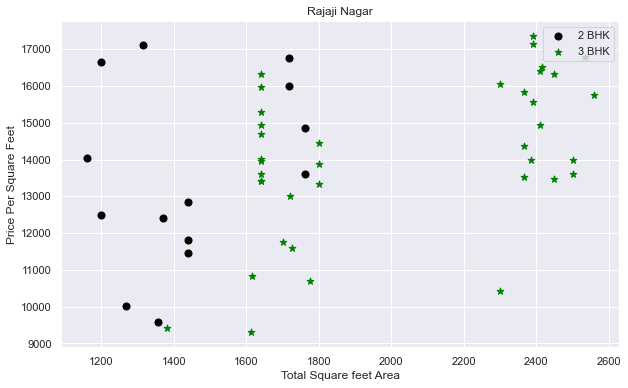

In [37]:
plot_scatter_chart(Data7, 'Rajaji Nagar');
plt.show()

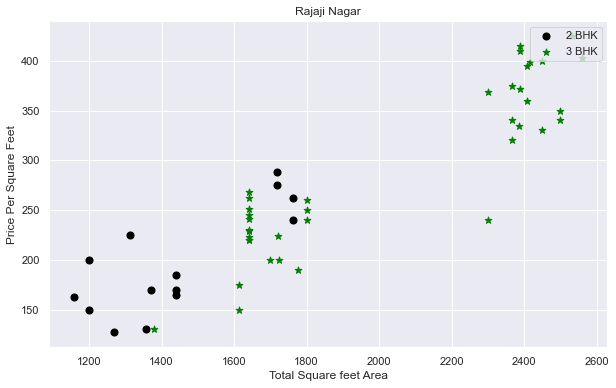

In [38]:
plot_scatter_chart2(Data7, 'Rajaji Nagar');
plt.show()

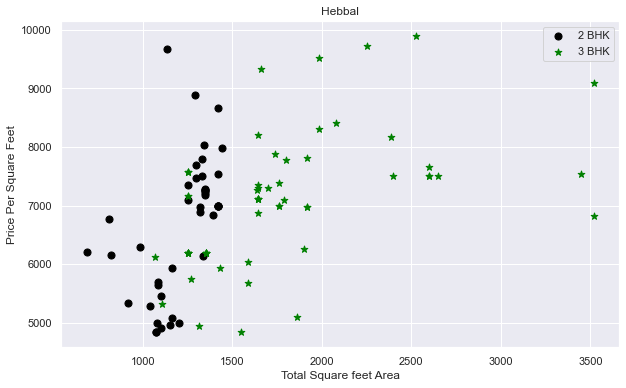

In [39]:
plot_scatter_chart(Data7, 'Hebbal');
plt.show()

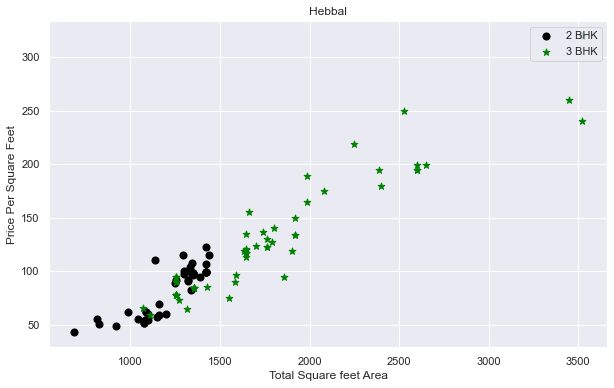

In [40]:
plot_scatter_chart2(Data7, 'Hebbal');
plt.show()

In [41]:
def remove_bhk_outliers(Data):
    exclude_indices = np.array([])
    for location, location_Data in Data.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_Data in location_Data.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_Data.price_per_sqft),
                'std': np.std(bhk_Data.price_per_sqft),
                'count': bhk_Data.shape[0]
            }
        for bhk, bhk_Data in location_Data.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_Data[bhk_Data.price_per_sqft<(stats['mean'])].index.values)
    return Data.drop(exclude_indices, axis="index")

Data8 = remove_bhk_outliers(Data7)
Data8.shape

(7369, 7)

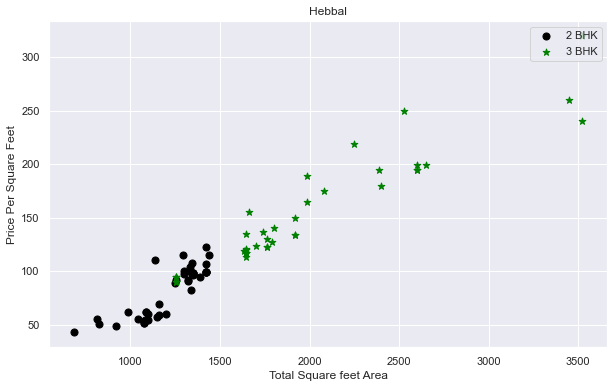

In [42]:
plot_scatter_chart2(Data8, 'Hebbal');
plt.show()

Text(0, 0.5, 'Count')

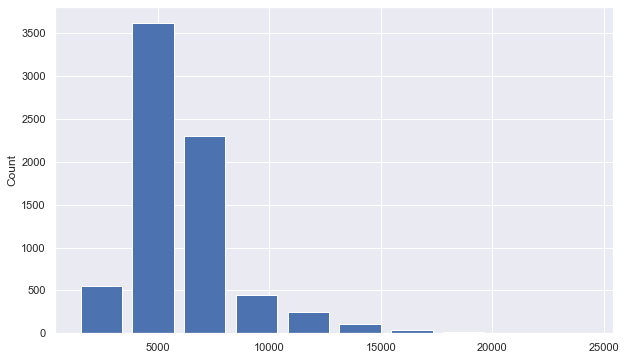

In [43]:
# Plotting a Histogram

plt.hist(Data8.price_per_sqft, rwidth = 0.8)
plt.xlabel = ('Price Per Square Feet')
plt.ylabel("Count")

In [44]:
# Exploring The bathroom Features
Data8.bath.unique()
Data8[Data8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
585,BTM 1st Stage,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
5344,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8547,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8633,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9329,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9642,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


Text(0, 0.5, 'Count')

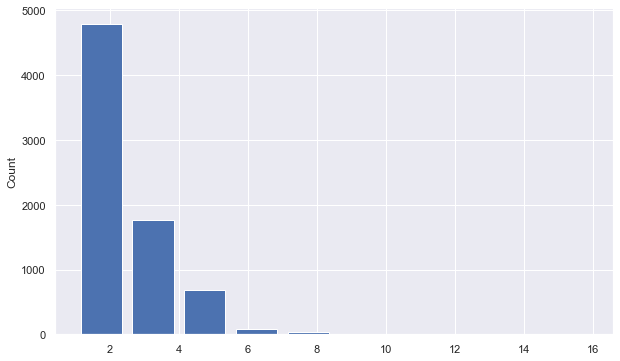

In [45]:
# Visualizing The Bathroom Feature using a Histogram

plt.hist(Data8.bath, rwidth = 0.8)
plt.xlabel = ('Number of Bathrooms')
plt.ylabel("Count")

In [46]:
#Detecting the outlier Using the criteria

Data8[Data8.bath>Data8.bhk+2]

Data9 = Data8[Data8.bath<Data8.bhk+2]
Data9.shape

(7291, 7)

In [47]:
# Dropping the size price_per_sqft_feature

Data10 = Data9.drop(["size","price_per_sqft"], axis="columns")
Data10.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


In [48]:
#One_Hot_Encoding and Model Building

dummies = pd.get_dummies(Data10.location)
dummies.head()

,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
Data11 = pd.concat([Data10, dummies.drop("other", axis="columns")], axis="columns")
Data11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
Data12 = Data11.drop("location", axis="columns")
Data12.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Block Koramangala,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
X = Data12.drop("price", axis = "columns")
y = Data12.price

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=10)

In [52]:
model = LinearRegression()
model.fit(X_train, y_train)
print('Your Accuracy is: ', model.score(X_test, y_test) )

Your Accuracy is:  0.8556662450160853


In [53]:
# Saving the model

with open("bangalore_home_prices_model", "wb") as f:
    pickle.dump(model, f)

In [55]:
# Using Cross Validtion to get the best model
#creating a shufflesplit will randomize the sample and give a better accuracy

from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X,y, cv=cv)

array([0.84196276, 0.82904236, 0.90136194, 0.85131228, 0.84354632])

In [63]:
#Try other models to figure out which one gives the best score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

#We now write a function

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        "linear_regression":{
            "model":LinearRegression(),
            "params":{
                "normalize":[True, False]
            }
        },
        
        "lasso": {
            "model": Lasso(),
            "params": {
                "alpha": [1,2],
                "selection": ["random", "cyclic"]
            }
        },
        
        "decision_tree": {
            "model": DecisionTreeRegressor(),
            "params": {
                "criterion": ["mse", "friedman_mse"],
                "splitter": ["best", "random"]
            }
        }
    }
    
    #To save the model into a dataframe
    
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config["model"], config["params"], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            "model":algo_name,
            "best_score":gs.best_score_,
            "best_params":gs.best_params_
        })
        
    return pd.DataFrame(scores, columns=["model","best_score", "best_params"])

# Calling the model

find_best_model_using_gridsearchcv(X,y)
    

,model,best_score,best_params
0,linear_regression,0.853445,{'normalize': False}
1,lasso,0.703398,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.685023,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


In [69]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Block Koramangala', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=257)

In [74]:
# We now write a function to predict prices

def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]
    
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    
    if loc_index >= 0:
        x[loc_index] = 1
    return model.predict([x])[0]

# we now make predictions

predict_price("1st Phase JP Nagar", 1000, 2, 2)

86.10543612201245

In [83]:
import math
price = predict_price("1st Phase JP Nagar", 1000, 3, 3)

print(math.ceil(price))

88


In [84]:
#saving into a JSON file
import json
columns = {
    "data_columns": [col.lower() for col in X.columns]
}

with open("columns.json", "w") as f:
    f.write(json.dumps(columns))

In [ ]:
#model = CatBoostRegressor()
#model.fit(X_train, y_train)
#print('Your Accuracy is: ', model.score(X_test, y_test) )